This Notebook 

In [1]:
#imports
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import matplotlib as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
#load train and test data-sets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train['Name'].astype(str)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
df_train['Title'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['Title'] = df_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_train = df_train.replace("Mlle", "Miss")
df_train['Title'] = df_train['Title'].replace('Ms', 'Miss')
df_train['Title']= df_train['Title'].replace('Mme', 'Mrs')
df_train = df_train.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_test = df_test.replace("Mlle", "Miss")
df_test['Title'] = df_test['Title'].replace('Ms', 'Miss')
df_test['Title']= df_test['Title'].replace('Mme', 'Mrs')
df_test = df_test.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

df_train["Title"].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

In [4]:
#pre-processing the data
def drop_features (df): #drop irrelevant features
    return df.drop(columns=["Name","Ticket"],inplace=True)
def person (passenger): #to test whether children have higher odds of survival
    age, sex = passenger
    if age > 18:
        return sex
    else:
        return "child"
drop_features(df_train)
drop_features(df_test)
df_train['Person'] = df_train[['Age','Sex']].apply(person,axis=1)
df_test['Person'] = df_test[['Age','Sex']].apply(person,axis=1)

In [5]:
def bin_age(age): #binned age
    if age < 18:
        return 'Teen'
  # elif age < 32:
      #  return 'Young Adult'
    elif age < 48:
        return 'Adult'
    #elif age < 64:
     #   return 'Senior'
    elif age < 120:
        return 'Old'
df_train["Ref_Age"] = df_train["Age"].apply(bin_age)
df_test["Ref_Age"] = df_test["Age"].apply(bin_age)

In [6]:
Cabin = df_train['Cabin']
Cabin.fillna('N',inplace=True)
levels = []
for level in Cabin:
    levels.append(level[0])
    
df_train['Cabin'] = levels

Cabin_test = df_test['Cabin']
Cabin_test.fillna('N',inplace=True)
levels = []
for level in Cabin_test:
    levels.append(level[0])
    

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


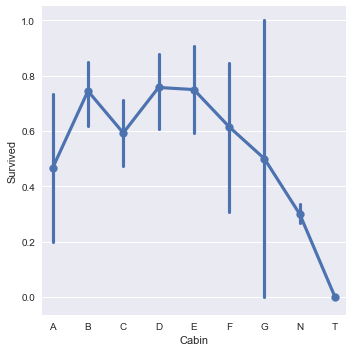

In [7]:
sns.factorplot(x = 'Cabin', y= 'Survived',data=df_train)

In [8]:
def refined_fare(fare): #bin them into the percentile ranges
    if fare < 0:
        return ("Unknown")
    elif fare < 8:
        return ("1st")
    #elif fare < 15:
     #   return ("2nd")
    elif fare < 31:
        return ("3rd")
    elif fare <515:
        return ("4th")
df_train["Fare"] = df_train["Fare"].apply(refined_fare)
df_test["Fare"] = df_test["Fare"].apply(refined_fare)

In [9]:
df_train["Family_size"] = df_train.SibSp + df_train.Parch
df_test["Family_size"] = df_test.SibSp + df_test.Parch

In [10]:
def Family_size_bin (family_size):
    if (family_size < 1):
        return "alone"
    elif (family_size < 5):
        return "medium"
    elif (family_size <11):
        return "large"
df_train["Bin_Family_size"]= df_train["Family_size"].apply(Family_size_bin)
df_test["Bin_Family_size"]= df_test["Family_size"].apply(Family_size_bin)

In [11]:
def is_alone (person):
    if (person == 0):
        return "Alone"
    else:
        return "Not Alone"
df_train["Alone"]= df_train["Family_size"].apply(is_alone)
df_test["Alone"]= df_test["Family_size"].apply(is_alone)

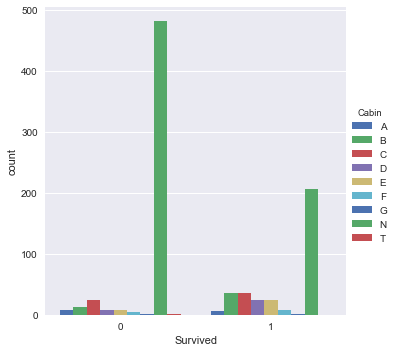

In [12]:
#Some visualisation
sns.factorplot("Survived",hue='Cabin',data=df_train)

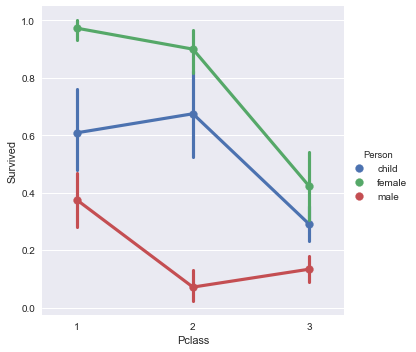

In [13]:
sns.factorplot("Pclass","Survived",data= df_train,hue='Person')

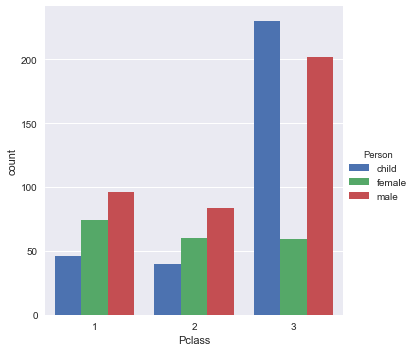

In [14]:
sns.factorplot(x='Pclass',data = df_train, hue = 'Person')

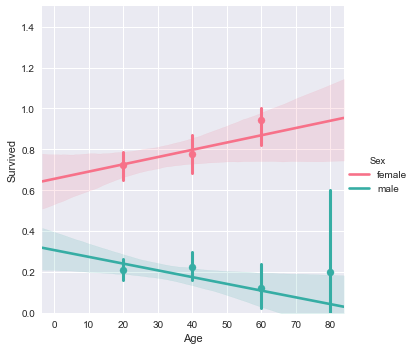

In [15]:
g = sns.lmplot("Age","Survived", hue = 'Sex',data = df_train, x_bins = [20,40,60,80])
g.set(ylim=(0,1.5))

In [16]:
df_train= df_train.drop(["Age","SibSp","Person","Parch","Cabin",'Family_size','Cabin'],axis=1)
df_test= df_test.drop(["Age","SibSp","Person","Parch","Cabin",'Family_size','Cabin'],axis=1)


In [23]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ["Sex","Ref_Age",'Title','Alone',"Embarked","Bin_Family_size","Fare"]
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
df_train, df_test = encode_features(df_train, df_test)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Title,Ref_Age,Bin_Family_size,Alone
0,1,0,3,1,1,3,2,1,2,1
1,2,1,1,0,3,1,3,1,2,1
2,3,1,3,0,1,3,1,1,0,0
3,4,1,1,0,3,3,3,1,2,1
4,5,0,3,1,2,3,2,1,0,0


In [24]:
from sklearn.model_selection import train_test_split

X_all = df_train.drop(["Survived", "PassengerId"], axis=1)
Y_all = df_train['Survived']

num_test = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=num_test)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf1 = RandomForestClassifier(n_estimators=150)

# Choose some parameter combinations to try

clf1.fit(X_all, Y_all)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
final_predictions = clf1.predict(X_test)
print(accuracy_score(Y_test,final_predictions))

0.865921787709


In [29]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(X_all,Y_all)
coeff_df = DataFrame(zip(X_all.columns, np.transpose(logistic_model.coef_)))
coeff_df


,0,1
0,Pclass,[-0.741613903554]
1,Sex,[-2.39844170386]
2,Fare,[0.159387102166]
3,Embarked,[-0.186447094306]
4,Title,[-0.234129662027]
5,Ref_Age,[0.246136151186]
6,Bin_Family_size,[1.12446570546]
7,Alone,[-2.0804704859]


In [30]:
from sklearn.svm import SVC
SVM = SVC(gamma=500)
SVM.fit(X_all,Y_all)
predictions2 = SVM.predict(X_all)
print(accuracy_score(Y_all, predictions2))

0.869809203143


In [31]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        Y_train, Y_test = Y_all.values[train_index], Y_all.values[test_index]
        clf.fit(X_train, Y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, predictions)
        outcomes.append(accuracy)
        
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf1)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fold 1 accuracy: 0.777777777778
Fold 2 accuracy: 0.820224719101
Fold 3 accuracy: 0.752808988764
Fold 4 accuracy: 0.831460674157
Fold 5 accuracy: 0.842696629213
Fold 6 accuracy: 0.865168539326
Fold 7 accuracy: 0.808988764045
Fold 8 accuracy: 0.752808988764
Fold 9 accuracy: 0.85393258427
Fold 10 accuracy: 0.842696629213
Mean Accuracy: 0.814856429463


In [ ]:
ids = df_test['PassengerId']
predictions = clf1.predict(df_test.drop('PassengerId', axis=1))
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('123456.csv', index = False)
output.head()